In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

In [5]:
# Medians of the Moffat parameters
moffat_medians = {'g_alpha': 0.86, 'g_beta': 2.48, 'r_alpha': 0.67, 'r_beta': 2.23, 'z_alpha': 0.51, 'z_beta': 2.00}

# DECam - GAIA range
g_min, g_max =  0.22, 1.90 
r_min, r_max =  -0.17, 0.41 
z_min, z_max =  -1.57, -0.09 
keys = ['g_min', 'g_max', 'r_min', 'r_max', 'z_min', 'z_max']
values = [g_min, g_max, r_min, r_max, z_min, z_max]
decam_gaia_ranges = {keys[i]: values[i] for i in range(len(keys))}

__Plot the PSF profiles (normalized to a 22.5 magnitude star)__

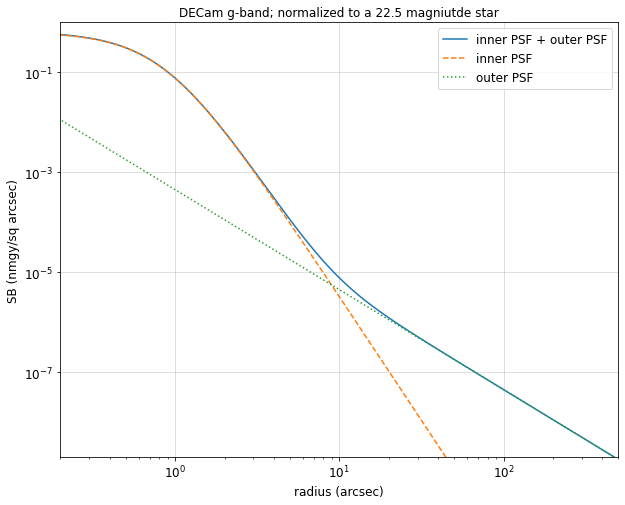

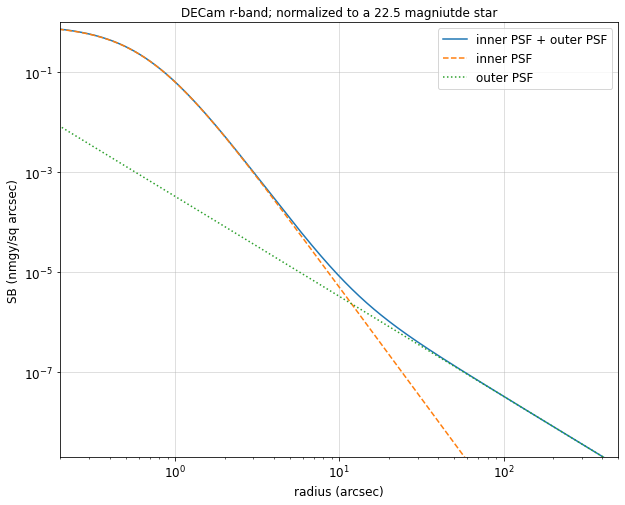

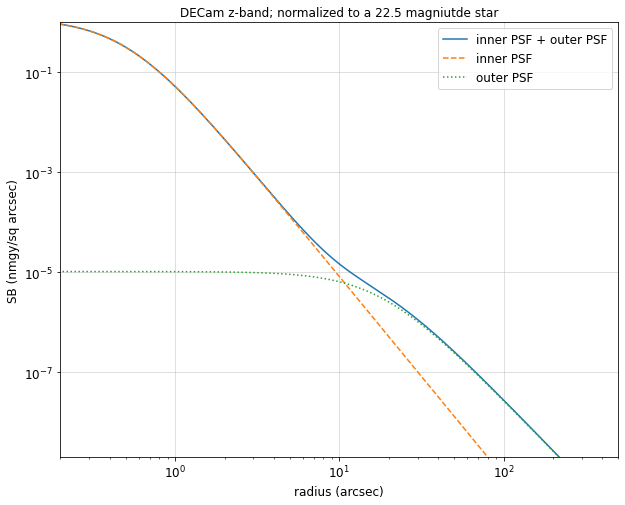

In [6]:
radius = np.logspace(-1, np.log10(500), 1000)

for band in ['g', 'r', 'z']:
    
    alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']
    
    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    plt.figure(figsize=(10, 8))
    plt.loglog(radius, flux_all, '-', lw=1.5, label='inner PSF + outer PSF')
    plt.loglog(radius, flux_inner, '--', lw=1.5, alpha=1, label='inner PSF')
    plt.loglog(radius, flux_outer, ':', lw=1.5, alpha=1, label='outer PSF')
    plt.axis([0.2, 500, 2e-9, 1.])
    plt.grid(alpha=0.5)
    plt.title('DECam {}-band; normalized to a 22.5 magniutde star'.format(band))
    plt.xlabel('radius (arcsec)')
    plt.ylabel('SB (nmgy/sq arcsec)')
    plt.legend(markerscale=7)
    plt.show()

-------
## Plot the radius-magnitude relation (which is the inverse of the PSF profiles)

__Overplot the DR8 GAIA magnitude-radius relation__

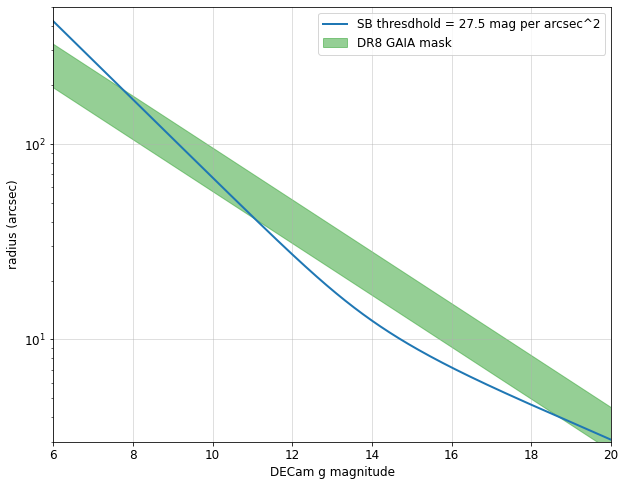

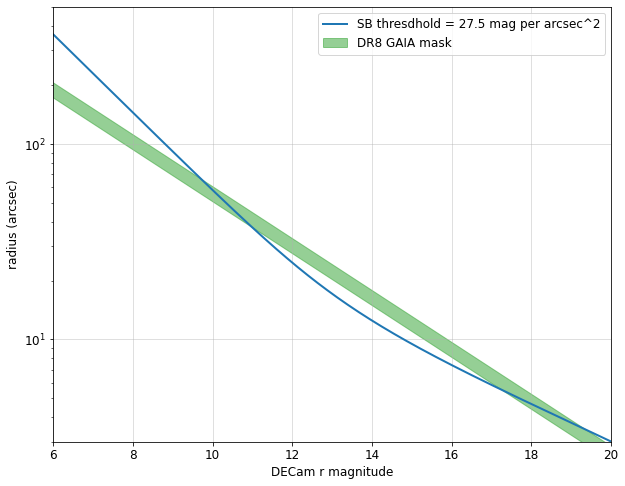

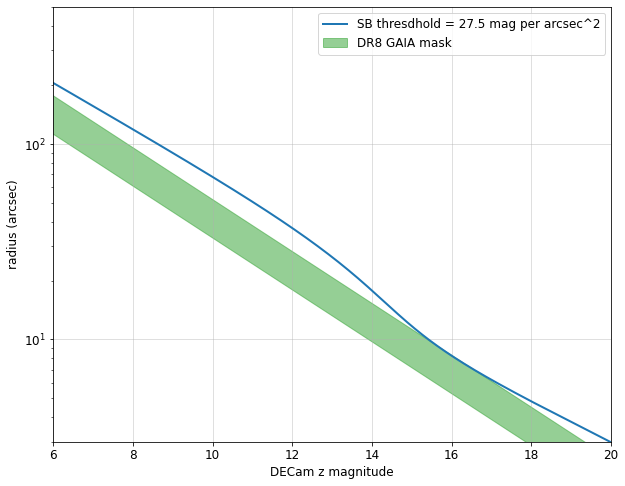

In [8]:
for band in ['g', 'r', 'z']:

    alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

    radius = np.logspace(-1, np.log10(500), 1000)

    sb_limit_in_mag = 27.5
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
    mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)

    # compare with DR8 GAIA mask
    gaia_radius_min = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_min']))/3.)) * 0.262
    gaia_radius_max = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_max']))/3.)) * 0.262
    
    plt.figure(figsize=(10, 8))
    plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:.1f} mag per arcsec^2'.format(sb_limit_in_mag))
    # plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
    plt.fill_between(mag_at_radius, gaia_radius_min, gaia_radius_max, alpha=0.5, label='DR8 GAIA mask', color='C2')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('DECam {} magnitude'.format(band))
    plt.ylabel('radius (arcsec)')
    # plt.axhline(5., lw=2, ls='--', color='k')
    plt.axis([6, 20, 3, 500])
    plt.legend()
    plt.show()

__1 mag brighter for z-band__

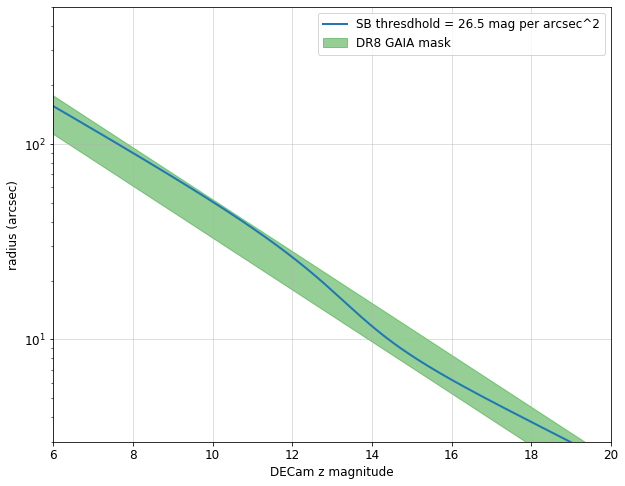

In [8]:
band = 'z'

alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 26.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

# nanomaggies per sq arcsec:
if band!='z':
    plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
    flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * radius**(plexp2)
else:
    alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
    flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)

# compare with DR8 GAIA mask
gaia_radius_min = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_min']))/3.)) * 0.262
gaia_radius_max = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_max']))/3.)) * 0.262

plt.figure(figsize=(10, 8))
plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:.1f} mag per arcsec^2'.format(sb_limit_in_mag))
# plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
plt.fill_between(mag_at_radius, gaia_radius_min, gaia_radius_max, alpha=0.5, label='DR8 GAIA mask', color='C2')
plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('DECam {} magnitude'.format(band))
plt.ylabel('radius (arcsec)')
# plt.axhline(5., lw=2, ls='--', color='k')
plt.axis([6, 20, 3, 500])
plt.legend()
plt.show()

__Approximation with two linear functions__

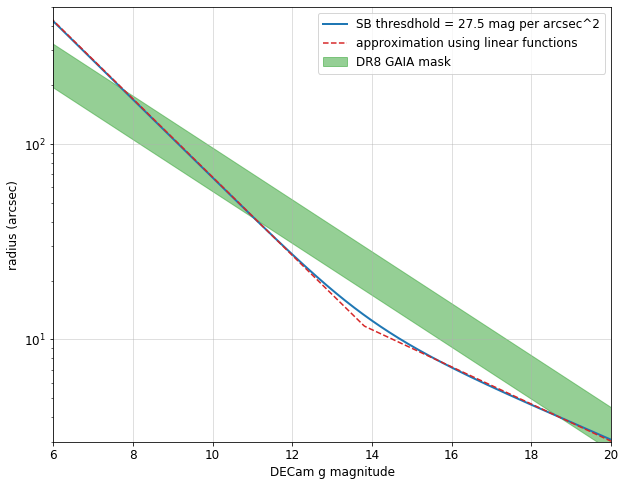

In [9]:
# for band in ['g', 'r', 'z']:

band = 'g'

alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

radius = np.logspace(-1, np.log10(500), 1000)

sb_limit_in_mag = 27.5
sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

# nanomaggies per sq arcsec:
if band!='z':
    plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
    flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * radius**(plexp2)
else:
    alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
    flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
    flux_inner = get_sb_moffat(radius, alpha, beta)
    flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)

# compare with DR8 GAIA mask
gaia_radius_min = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_min']))/3.)) * 0.262
gaia_radius_max = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_max']))/3.)) * 0.262

x = mag_at_radius
y1 = -0.2*x + 3.83
y2 = -0.095*x + 2.38
y = np.maximum(y1, y2)

plt.figure(figsize=(10, 8))
plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:.1f} mag per arcsec^2'.format(sb_limit_in_mag))
# # plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
plt.semilogy(x, 10**y, '--', alpha=1, label='approximation using linear functions', color='C3')
plt.fill_between(mag_at_radius, gaia_radius_min, gaia_radius_max, alpha=0.5, label='DR8 GAIA mask', color='C2')
plt.grid(alpha=0.5)
# plt.title(' ')
plt.xlabel('DECam {} magnitude'.format(band))
plt.ylabel('radius (arcsec)')
# plt.axhline(5., lw=2, ls='--', color='k')
plt.axis([6, 20, 3, 500])
plt.legend()
plt.show()

__If we adopt the g-band brightness profile for masking (still relying on GAIA):__

__NEED To CHECK IF IT'S CORRECT!!__

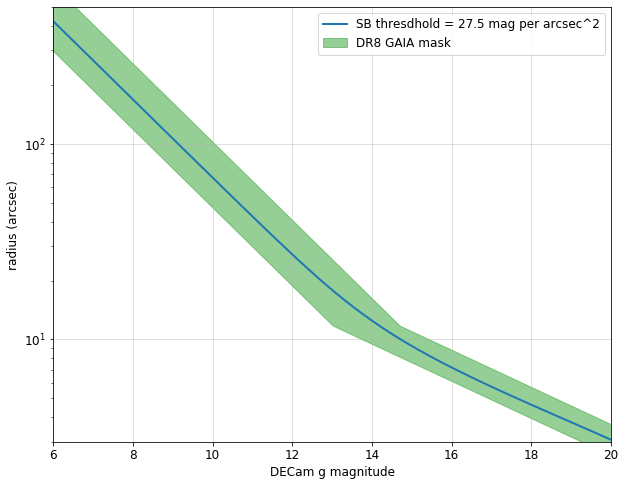

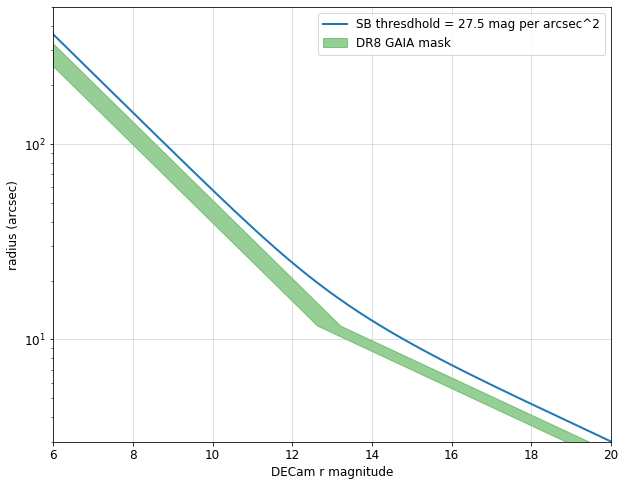

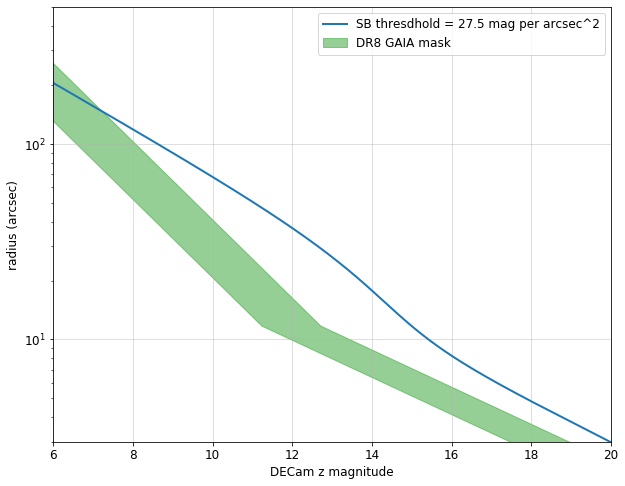

In [10]:
for band in ['g', 'r', 'z']:

    alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

    radius = np.logspace(-1, np.log10(500), 1000)

    sb_limit_in_mag = 27.5
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
    mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)

    # compare with DR8 GAIA mask
    gaia_radius_min = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_min']))/3.)) * 0.262
    gaia_radius_max = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_max']))/3.)) * 0.262

    x = mag_at_radius
    y1 = -0.2*x + 3.83
    y2 = -0.095*x + 2.38
    gaia_radius = 10**(np.maximum(y1, y2))
    mag_at_radius_min = x -1 + decam_gaia_ranges[band+'_max']
    mag_at_radius_max = x -1 + decam_gaia_ranges[band+'_min']

    plt.figure(figsize=(10, 8))
    plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:.1f} mag per arcsec^2'.format(sb_limit_in_mag))
    # plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
    plt.fill_betweenx(gaia_radius, mag_at_radius_min, mag_at_radius_max, alpha=0.5, label='DR8 GAIA mask', color='C2')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('DECam {} magnitude'.format(band))
    plt.ylabel('radius (arcsec)')
    # plt.axhline(5., lw=2, ls='--', color='k')
    plt.axis([6, 20, 3, 500])
    plt.legend()
    plt.show()

-------
## Include variation in Moffat parameters

In [11]:
surveyccd = fitsio.read('/Users/rongpu/Documents/Data/desi_misc/survey-ccds-decam-dr9-cut.fits.gz', columns=['expnum', 'ccd_cuts'])
surveyccd = Table(surveyccd)
print(len(surveyccd))

mask = surveyccd['ccd_cuts']==0
surveyccd = surveyccd[mask]
print(len(surveyccd))

moffat_params = Table.read('/Users/rongpu/Documents/Data/desi_misc/bright_star_profiles/survey-ccds-decam-dr9-cut-psfex-moffat-params-subsample.fits')
print(len(moffat_params))

mask = np.in1d(moffat_params['expnum'], np.unique(surveyccd['expnum']))
moffat_params = moffat_params[mask]
print(len(moffat_params))

6388338
4881022
120616
91802


__Plot the PSF profiles (normalized to a 22.5 magnitude star)__

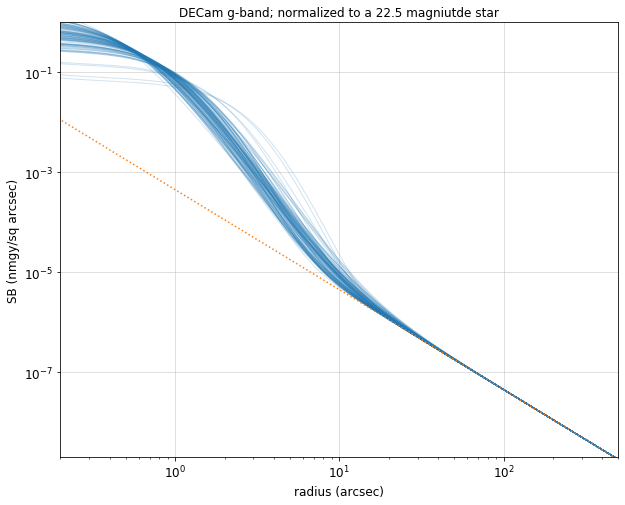

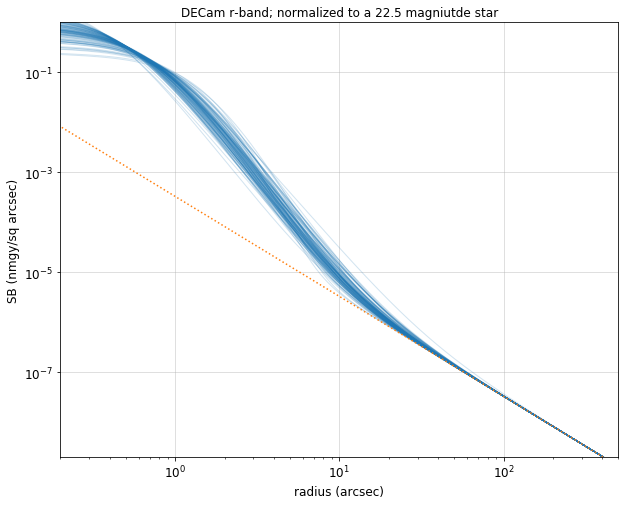

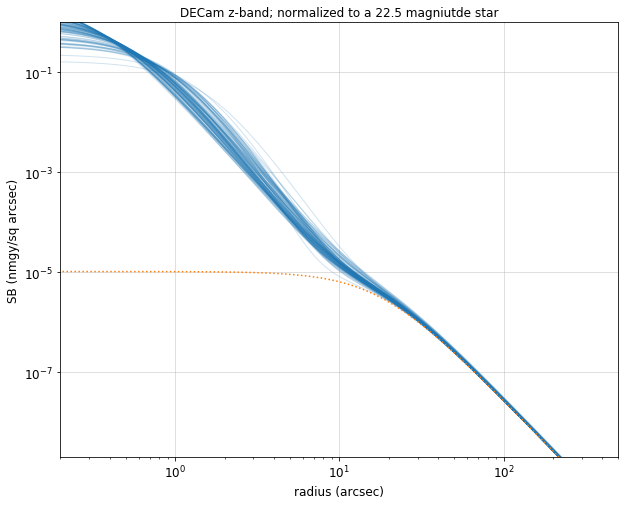

In [12]:
radius = np.logspace(-1, np.log10(500), 1000)

for band in ['g', 'r', 'z']:
    
    mask = moffat_params['filter']==band
    expnum_list = np.random.choice(np.unique(moffat_params['expnum'][mask]), size=100, replace=False)
    
    plt.figure(figsize=(10, 8))

    for expnum in expnum_list:
        
        index = np.random.choice(np.where(moffat_params['expnum']==expnum)[0])
        alpha, beta = moffat_params['moffat_alpha'][index], moffat_params['moffat_beta'][index]

        if moffat_params['filter'][index]!=band:
            raise ValueError

        # nanomaggies per sq arcsec:
        if band!='z':
            plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
            flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * radius**(plexp2)
        else:
            alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
            flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

        plt.loglog(radius, flux_all, '-', lw=1, alpha=0.2, c='C0')

    plt.loglog(radius, flux_outer, ':', lw=1.5, alpha=1, c='C1')
    plt.axis([0.2, 500, 2e-9, 1.])
    plt.grid(alpha=0.5)
    plt.title('DECam {}-band; normalized to a 22.5 magniutde star'.format(band))
    plt.xlabel('radius (arcsec)')
    plt.ylabel('SB (nmgy/sq arcsec)')
    # plt.legend(markerscale=7)
    plt.show()

__Plot the radius-magnitude relation (which is the inverse of the PSF profiles)__

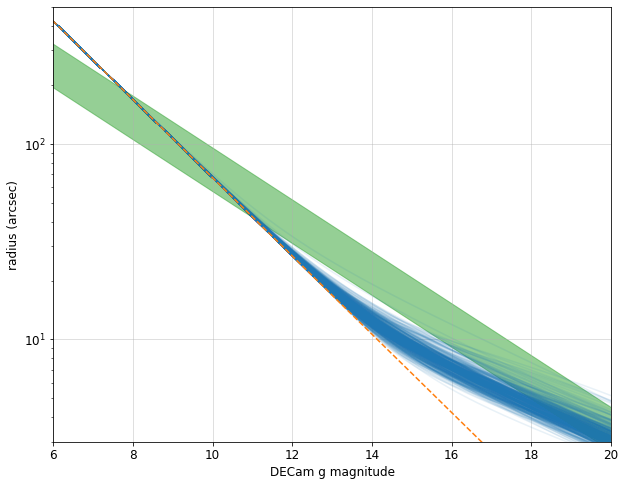

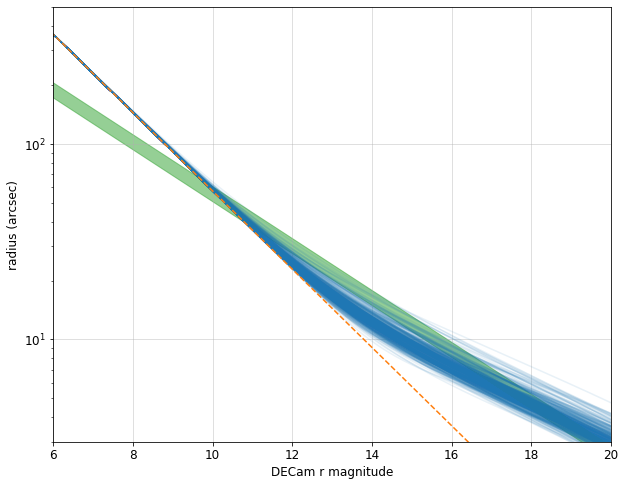

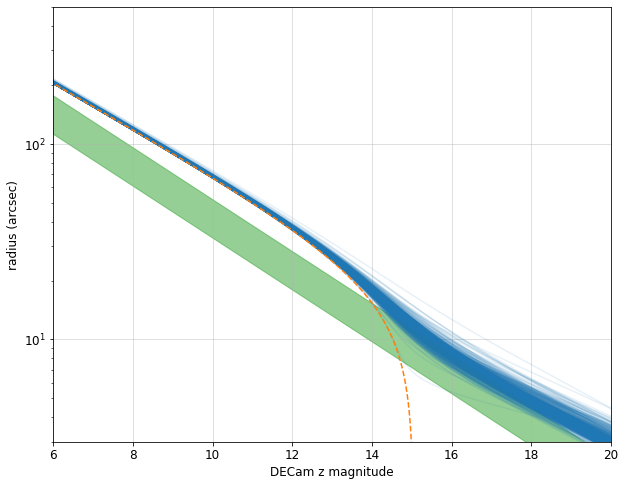

In [13]:
for band in ['g', 'r', 'z']:

    mask = moffat_params['filter']==band
    expnum_list = np.random.choice(np.unique(moffat_params['expnum'][mask]), size=400, replace=False)

    plt.figure(figsize=(10, 8))

    for expnum in expnum_list:
        
        index = np.random.choice(np.where(moffat_params['expnum']==expnum)[0])
        alpha, beta = moffat_params['moffat_alpha'][index], moffat_params['moffat_beta'][index]
        
        if moffat_params['filter'][index]!=band:
            raise ValueError

        radius = np.logspace(-1, np.log10(500), 1000)

        sb_limit_in_mag = 27.5
        sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

        # nanomaggies per sq arcsec:
        if band!='z':
            plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
            flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * radius**(plexp2)
        else:
            alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
            flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
            flux_inner = get_sb_moffat(radius, alpha, beta)
            flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

        mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
        mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)
        
        plt.semilogy(mag_at_radius, radius, '-', lw=1.5, c='C0', alpha=0.1)

    plt.semilogy(mag_at_radius_outer, radius, '--', lw=1.5, c='C1', alpha=1)

    # compare with DR8 GAIA mask
    gaia_radius_min = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_min']))/3.)) * 0.262
    gaia_radius_max = np.minimum(1800., 150. * 2.5**((11. - (mag_at_radius-decam_gaia_ranges[band+'_max']))/3.)) * 0.262

    plt.fill_between(mag_at_radius, gaia_radius_min, gaia_radius_max, alpha=0.5, label='DR8 GAIA mask', color='C2')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('DECam {} magnitude'.format(band))
    plt.ylabel('radius (arcsec)')
    # plt.axhline(5., lw=2, ls='--', color='k')
    plt.axis([6, 20, 3, 500])
    # plt.legend()
    plt.show()